In [1]:
!cd /content/PCG-arrhythmia-detection && python3 ./src/trainer.py

/bin/bash: line 0: cd: /content/PCG-arrhythmia-detection: No such file or directory


In [2]:
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
import sys

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:

#        torch.save([model.generator.state_dict(), model.discriminator.state_dict()], "/content/model.pt")

net = (torch.load("/content/model.pt"))
generator = dict(net[0])
discriminator = dict(net[1])

for x in generator:
  #print(x, generator[x].shape)
  if len(generator[x].shape) == 2:
    plt.imshow(generator[x].numpy())
    plt.show()

  

ModuleNotFoundError: ignored

In [7]:
import os
import time
import sys
from stat import S_ISREG, ST_CTIME, ST_MODE
dir_path = "/content/validation"
# get all entries in the directory
entries = (os.path.join(dir_path, file_name) for file_name in os.listdir(dir_path))
# Get their stats
entries = ((os.stat(path), path) for path in entries)
# leave only regular files, insert creation date
entries = [path
           for stat, path in entries if S_ISREG(stat[ST_MODE])]

outputs = []
targets = []

for i, fn in enumerate(entries):
  stats = torch.load(fn)
  output = []
  target = []
  for out, targ in stats:
    for x, y in zip(out, targ):
      output.append(x.cpu().numpy().tolist())
      target.append(y.cpu().numpy().tolist())
  outputs.append(output)
  targets.append(target)

torch.save({"out":outputs, "target": targets}, "/content/drive/MyDrive/datasets/outputs_epoch.pt")
torch.save({"out":outputs, "target": targets}, "/content/outputs_epoch.pt")

FileNotFoundError: ignored

In [ ]:
out_epoch = torch.load("/content/outputs_epoch.pt")
outputs = out_epoch["out"]
targets = out_epoch["target"]
print("Output Epochs Collected: ", len(out_epoch["out"]))
print("Target Epochs Collected: ", len(out_epoch["target"]))

Output Epochs Collected:  101
Target Epochs Collected:  101


In [ ]:
epochs_accs = []
for epoch in range(0, 100+1):
    labels = targets[epoch]
    pred = np.argmax(outputs[epoch], axis=1)
    acc = accuracy_score(labels, pred)
    epochs_accs.append([epoch, acc])
epochs_accs = np.array(epochs_accs)
sorted_epochs = epochs_accs[epochs_accs[:,1].argsort()][:,0].astype(int).tolist()
epochs_accs = epochs_accs.astype(float).tolist()

In [ ]:
print(epochs_accs)
print(sorted_epochs)

[[0.0, 0.9305949008498584], [1.0, 0.6430594900849859], [2.0, 0.8980169971671388], [3.0, 0.0], [4.0, 0.8427762039660056], [5.0, 0.9504249291784702], [6.0, 0.5991501416430595], [7.0, 0.839943342776204], [8.0, 0.6090651558073654], [9.0, 0.7521246458923513], [10.0, 0.8838526912181303], [11.0, 0.9419263456090652], [12.0, 0.7308781869688386], [13.0, 0.9150141643059491], [14.0, 0.7507082152974505], [15.0, 0.8980169971671388], [16.0, 0.0], [17.0, 0.7563739376770539], [18.0, 0.9348441926345609], [19.0, 0.78328611898017], [20.0, 0.9220963172804533], [21.0, 0.896600566572238], [22.0, 0.9376770538243626], [23.0, 0.9036827195467422], [24.0, 0.6543909348441926], [25.0, 0.9277620396600567], [26.0, 0.9305949008498584], [27.0, 0.9206798866855525], [28.0, 0.943342776203966], [29.0, 0.9164305949008499], [30.0, 0.5], [31.0, 0.93342776203966], [32.0, 0.640625], [33.0, 0.9277620396600567], [34.0, 0.773371104815864], [35.0, 0.0], [36.0, 0.8286118980169972], [37.0, 0.5524079320113314], [38.0, 0.81586402266288

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
from tqdm import tqdm
from sklearn.metrics import accuracy_score
plt.style.use('ggplot')

def norm(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)

    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range

colors_per_class = [["Normal", "b"], ["Abnormal", "r"], ["Artifact", "g"]]

epochs = range(5, 105, 5)
#epochs = iter([0, 100]) 
fig, axs = plt.subplots(4, 5, sharex=True, sharey=True, figsize=(30, 25), dpi=300)

for n, e in tqdm(enumerate(epochs)):
  epoch = sorted_epochs[e]

  x, y = int(n/5), n%5

  tsne = TSNE(n_components=2).fit_transform(outputs[epoch])
  tsne[:, 0] = norm(tsne[:, 0])
  tsne[:, 1] = norm(tsne[:, 1])

  axs[x][y].set_title(f"Epoch {e}")
  axs[x][y].set_aspect(1)
  for i, t in enumerate(tsne):
      tx, ty = t
      #print(np.argmax(outputs[epoch][i]), targets[epoch][i], colors_per_class[np.argmax(outputs[epoch][i])])
      label, color = colors_per_class[targets[epoch][i]]
      axs[x][y].scatter(tx, ty, c=color, zorder = 2 if label=="Normal" else 1)

fig.suptitle("t-SNE Visualization of Discriminator over Epochs")
fig.legend(["Abnomral Heart Sounds", "Nomral Heart Sounds"])
plt.savefig("/content/t-SNE_Discriminator.png")
plt.show()

20it [02:38,  7.94s/it]


In [8]:
fns = os.listdir("/content/models")
fns.sort()

epoch_model_data = {}

for i, fn in tqdm(enumerate(fns)):
  model_data = torch.load("/content/models/"+fn)
  epoch_model_data[model_data["epoch"]] = model_data["state_dict"]

torch.save(epoch_model_data, "/content/drive/MyDrive/datasets/epoch_model_data.pt")

FileNotFoundError: ignored

In [ ]:
!pip install pytorch-lightning

In [31]:
import sys
import torch
import torch.nn as nn


class CNN_A(nn.Module):
    def __init__(self):
        super().__init__()

        # Model Layer Declaration
        self.conv1 = nn.Conv1d(1, 16, kernel_size=5, stride=2)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, stride=2)
        self.conv3 = nn.Conv1d(32, 64, kernel_size=5, stride=2)
        self.dense1 = nn.Linear(64*309, 512)
        self.dense2 = nn.Linear(512, 256)
        self.dense3 = nn.Linear(256, 3)

    def forward(self, x):

        x = x.reshape(x.shape[0], 1, -1)

        # Convolutional Layer
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.conv3(x)
        x = nn.functional.relu(x)

        # Flattening
        x = x.reshape(x.shape[0], -1)

        # Dense Layers
        x = self.dense1(x)
        x = nn.functional.relu(x)
        x = self.dense2(x)
        x = nn.functional.relu(x)
        x = self.dense3(x)

        return x
net = CNN_A()

In [19]:
data = torch.load("/content/drive/MyDrive/datasets/models/e81.ckpt")

In [29]:
CNN_dict = {layer[14:]: data["state_dict"][layer] for layer in data["state_dict"].keys() if "generator" not in layer}

In [32]:
net.load_state_dict(CNN_dict)

<All keys matched successfully>

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
from tqdm import tqdm
from sklearn.metrics import accuracy_score
plt.style.use('ggplot')

def norm(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)

    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range

colors_per_class = [["Normal", "b"], ["Abnormal", "r"], ["Artifact", "g"]]

epochs = range(5, 105, 5)
#epochs = iter([0, 100]) 
fig, axs = plt.subplots(4, 5, sharex=True, sharey=True, figsize=(30, 25), dpi=300)

for n, e in tqdm(enumerate(epochs)):
  epoch = sorted_epochs[e]

  x, y = int(n/5), n%5

  tsne = TSNE(n_components=2).fit_transform(outputs[epoch])
  tsne[:, 0] = norm(tsne[:, 0])
  tsne[:, 1] = norm(tsne[:, 1])

  axs[x][y].set_title(f"Epoch {e}")
  axs[x][y].set_aspect(1)
  for i, t in enumerate(tsne):
      tx, ty = t
      #print(np.argmax(outputs[epoch][i]), targets[epoch][i], colors_per_class[np.argmax(outputs[epoch][i])])
      label, color = colors_per_class[targets[epoch][i]]
      axs[x][y].scatter(tx, ty, c=color, zorder = 2 if label=="Normal" else 1)

fig.suptitle("t-SNE Visualization of Discriminator over Epochs")
fig.legend(["Abnomral Heart Sounds", "Nomral Heart Sounds"])
plt.savefig("/content/t-SNE_Discriminator.png")
plt.show()

In [42]:
outputs = torch.load("/content/drive/MyDrive/datasets/outputs_epoch.pt")

In [44]:
outputs.keys()

dict_keys(['out', 'target'])

In [45]:
out,targ = outputs["out"][-1], outputs["target"][-1]

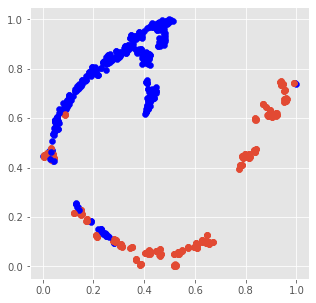

In [79]:
from sklearn.manifold import TSNE
plt.style.use('ggplot')

def norm(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)

    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range

colors_per_class = [["Normal", "b"], ["Abnormal", "#E24A33"], ["Artifact", "g"]]
plt.rcParams["figure.figsize"] = (5, 5)
out,targets = outputs["out"][0], outputs["target"][0]
tsne = TSNE(n_components=2).fit_transform(out)
tsne[:, 0] = norm(tsne[:, 0])
tsne[:, 1] = norm(tsne[:, 1])

for i, t in enumerate(tsne):
    tx, ty = t
    color = colors_per_class[targets[i]][-1]
    plt.scatter(tx, ty, c=color)
plt.show()

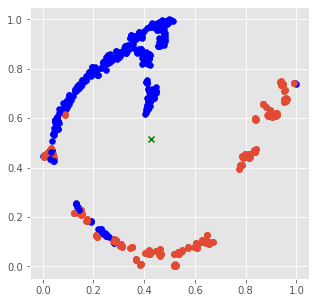

In [81]:
from sklearn.cluster import KMeans
import numpy as np

cls = [[],[]]
for i, c in enumerate(targets):
  cls[c].append(tsne[c])


for i, t in enumerate(tsne):
    tx, ty = t
    color = colors_per_class[targets[i]][-1]
    plt.scatter(tx, ty, c=color)
kmeans = KMeans(n_clusters=2, random_state=0).fit(tsne)

for x, y in kmeans.cluster_centers_:
  plt.scatter(x,y,marker="x", c="g")

plt.show()


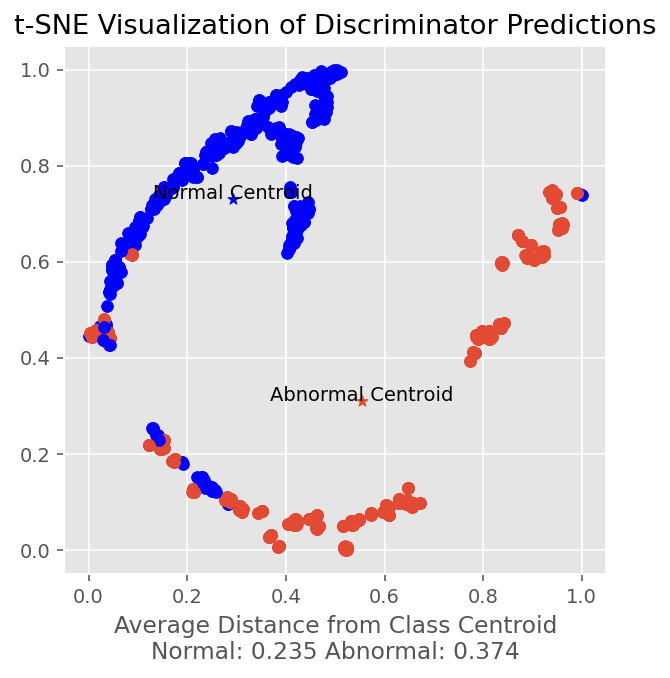

In [120]:
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

cls = [[],[]]
for i, c in enumerate(targets):
  cls[c].append(tsne[i])

plt.rcParams['figure.figsize'] = (5,5)
plt.rcParams['figure.dpi'] = 140

for i, t in enumerate(tsne):
    tx, ty = t
    color = colors_per_class[targets[i]][-1]
    plt.scatter(tx, ty, c=color)

cls_dist = []

for r, cluster in enumerate(cls):
  kmeans = KMeans(n_clusters=1, random_state=0).fit(cluster)
  for x, y in kmeans.cluster_centers_:
    plt.scatter(x,y,marker="*", c=colors_per_class[r][-1], )
    dist = [euclidean_distances([[x,y]], [point]).flatten().tolist() for point in cluster]
    cls_dist.append(np.mean(dist))
    plt.annotate(f"{colors_per_class[r][0]} Centroid", (x, y), ha='center')

plt.xlabel(f"Average Distance from Class Centroid\nNormal: {round(cls_dist[0], 3)} Abnormal: {round(cls_dist[1],3)}")
plt.title("t-SNE Visualization of Discriminator Predictions", fontdict={"size":14})
plt.show()

In [90]:
print(dist)

[array([[0.10812992]]), array([[0.22489056]]), array([[0.1229732]]), array([[0.10192873]]), array([[0.15255295]]), array([[0.30272546]]), array([[0.12512493]]), array([[0.19516547]]), array([[0.3368824]]), array([[0.19251057]]), array([[0.27872008]]), array([[0.16631211]]), array([[0.11907087]]), array([[0.28480427]]), array([[0.11125009]]), array([[0.11435222]]), array([[0.14311343]]), array([[0.27801625]]), array([[0.12512493]]), array([[0.20133684]]), array([[0.14557293]]), array([[0.14104835]]), array([[0.20289002]]), array([[0.15613392]]), array([[0.28589608]]), array([[0.14249605]]), array([[0.2494951]]), array([[0.5565496]]), array([[0.14647993]]), array([[0.16176647]]), array([[0.59008379]]), array([[0.28970467]]), array([[0.14484001]]), array([[0.14069053]]), array([[0.16574889]]), array([[0.39345386]]), array([[0.27702303]]), array([[0.21411622]]), array([[0.11461573]]), array([[0.13625386]]), array([[0.07718393]]), array([[0.33606228]]), array([[0.1172391]]), array([[0.37717

In [70]:
from sklearn.manifold import TSNE
plt.style.use('ggplot')

def norm(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)

    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

colors_per_class = [["Normal", "b"], ["Abnormal", "#E24A33"], ["Artifact", "g"]]
plt.rcParams["figure.figsize"] = (5, 5)
out,targets = outputs["out"][0], outputs["target"][0]
tsne = TSNE(n_components=3).fit_transform(out)
tsne[:, 0] = norm(tsne[:, 0])
tsne[:, 1] = norm(tsne[:, 1])
tsne[:, 2] = norm(tsne[:, 2])


for i, t in enumerate(tsne):
    tx, ty, tz = t
    color = colors_per_class[targets[i]][-1]
    ax.scatter(tx, ty, tz, c=color)
plt.show()

NameError: ignored